In [33]:
from nltk.tokenize import word_tokenize
import re
import pandas as pd
from nltk.corpus import stopwords
import spacy
import gensim
import multiprocessing
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from pathlib import Path
from tabulate import tabulate
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

In [34]:
breitbart = pd.read_csv("breitbart.csv")
dreams = pd.read_csv("commondreams.csv")
motherjones = pd.read_csv("motherjones.csv")

In [35]:
democrats = pd.concat([dreams["text"], motherjones["text"]], ignore_index=True)
democrats.dropna().to_csv("democrats.txt", index=False, header=False)

republicans = breitbart["text"].dropna()
republicans.to_csv("republicans.txt", index=False, header=False)

In [36]:
WINDOW = 5
OUT_DIR = Path("skipgrams")
OUT_DIR.mkdir(exist_ok=True)

stopwords_en = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000 


def skipgrammer(text, window_size):
    tokens = word_tokenize(text)
    res = []
    for idx, target in enumerate(tokens):
        start = max(0, idx - window_size)
        end   = min(len(tokens), idx + window_size + 1)
        for j in range(start, end):
            if j != idx:
                res.append((target, tokens[j]))
    return res


def corpus_chunks(text, chunk_size=100000):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield " ".join(words[i : i + chunk_size]), i // chunk_size


def process_corpus(raw_text, label):
    raw_text = re.sub(r"[.\n,]", " ", raw_text)
    raw_text = re.sub(r"\[[^\]]*?\]", "", raw_text)
    for chunk, n in corpus_chunks(raw_text):
        doc = nlp(chunk)
        lemmas = [tok.lemma_.lower() for tok in doc if tok.is_alpha and len(tok.lemma_) > 2 and tok.lemma_.lower() not in stopwords_en]
        clean = " ".join(lemmas)
        
        sg = skipgrammer(clean, WINDOW)

        out_file = OUT_DIR / f"{label}_skipgrams_{n:d}.pkl"
        with out_file.open("wb") as f:
            pickle.dump(sg, f)

        print(f"{label} chunk {n}: {len(sg)} skip-grams")

In [37]:
republicans_text = "\n".join(republicans.dropna().astype(str))
democrats_text = "\n".join(democrats.dropna().astype(str))

# запускаем пайплайн
print("=== Conservatives ===")
process_corpus(republicans_text, "cons")

print("\n=== Liberals ===")
process_corpus(democrats_text, "libs")

=== Conservatives ===
✓ cons — chunk 000: 554,410 skip-grams
✓ cons — chunk 001: 554,560 skip-grams
✓ cons — chunk 002: 556,300 skip-grams
✓ cons — chunk 003: 558,540 skip-grams
✓ cons — chunk 004: 440,750 skip-grams

=== Liberals ===
✓ libs — chunk 000: 573,530 skip-grams
✓ libs — chunk 001: 574,310 skip-grams
✓ libs — chunk 002: 572,890 skip-grams
✓ libs — chunk 003: 573,610 skip-grams
✓ libs — chunk 004: 549,610 skip-grams
✓ libs — chunk 005: 567,270 skip-grams
✓ libs — chunk 006: 555,760 skip-grams
✓ libs — chunk 007: 87,590 skip-grams


In [38]:
libs_all = []
for pkl_file in sorted(OUT_DIR.glob("libs_skipgrams_*.pkl")):
    with pkl_file.open("rb") as f:
        libs_all.extend(pickle.load(f))

with (OUT_DIR / "libs_skipgrams_all.pkl").open("wb") as f:
    pickle.dump(libs_all, f)

cons_all = []
for pkl_file in sorted(OUT_DIR.glob("cons_skipgrams_*.pkl")):
    with pkl_file.open("rb") as f:
        cons_all.extend(pickle.load(f))

with (OUT_DIR / "cons_skipgrams_all.pkl").open("wb") as f:
    pickle.dump(cons_all, f)

In [39]:
target = 'america'
target_skipgrams = []
for skipgram in libs_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

[(('pen', 'america'), 480), (('america', 'pen'), 480), (('say', 'america'), 294), (('america', 'say'), 294), (('america', 'social'), 243), (('social', 'america'), 243), (('america', 'bsky'), 240), (('bsky', 'america'), 240), (('director', 'america'), 126), (('america', 'director'), 126), (('movement', 'america'), 123), (('across', 'america'), 123), (('america', 'movement'), 123), (('america', 'across'), 123), (('america', 'deportation'), 123), (('deportation', 'america'), 123), (('press', 'america'), 123), (('america', 'press'), 123), (('free', 'america'), 123), (('america', 'free'), 123), (('america', 'tuesday'), 123), (('america', 'concern'), 123), (('tuesday', 'america'), 123), (('concern', 'america'), 123), (('border', 'america'), 120), (('america', 'border'), 120), (('america', 'follow'), 120), (('america', 'detainment'), 120), (('follow', 'america'), 120), (('detainment', 'america'), 120), (('org', 'america'), 120), (('relea', 'america'), 120), (('america', 'org'), 120), (('ameri

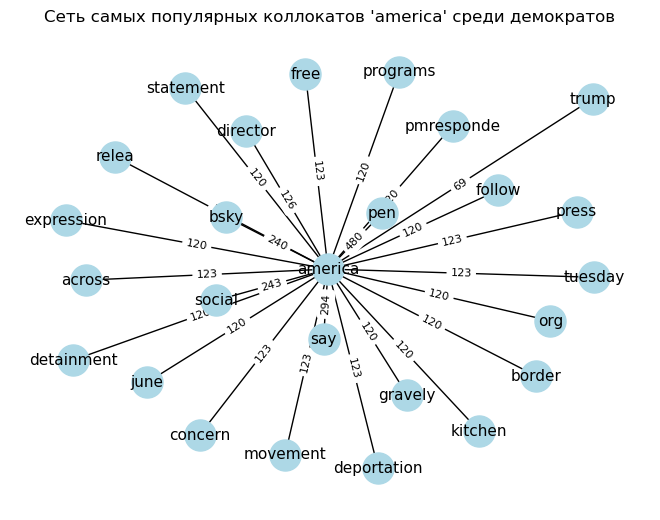

In [40]:
G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'america' среди демократов")
plt.show()

[(('america', 'first'), 243), (('first', 'america'), 243), (('say', 'america'), 234), (('america', 'say'), 234), (('america', 'trump'), 219), (('trump', 'america'), 219), (('america', 'america'), 150), (('america', 'president'), 147), (('president', 'america'), 147), (('israel', 'america'), 126), (('america', 'israel'), 126), (('american', 'america'), 123), (('america', 'american'), 123), (('make', 'america'), 114), (('america', 'make'), 114), (('america', 'people'), 114), (('people', 'america'), 114), (('owners', 'america'), 105), (('america', 'owners'), 105), (('member', 'america'), 102), (('gun', 'america'), 102), (('america', 'member'), 102), (('america', 'gun'), 102), (('states', 'america'), 99), (('america', 'states'), 99), (('united', 'america'), 96), (('america', 'united'), 96), (('radio', 'america'), 93), (('america', 'radio'), 93), (('america', 'great'), 87), (('great', 'america'), 87), (('america', 'global'), 84), (('global', 'america'), 84), (('death', 'america'), 81), (('a

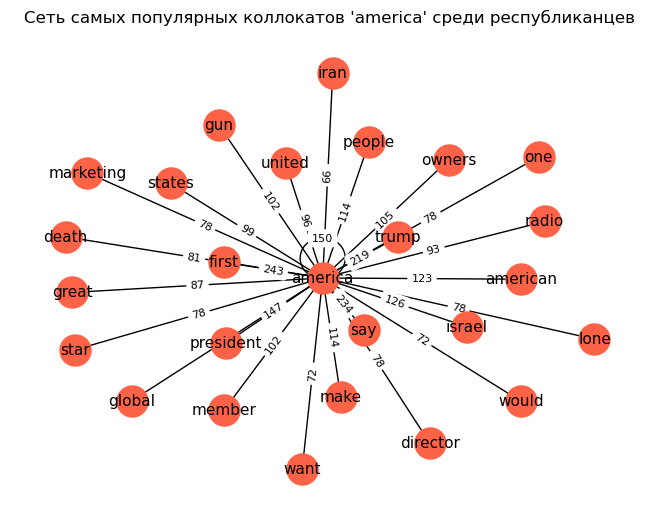

In [41]:
target = 'america'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'america' среди республиканцев")
plt.show()

Фильтрация существительных: 100%|██████████| 31050/31050 [01:09<00:00, 448.79it/s]


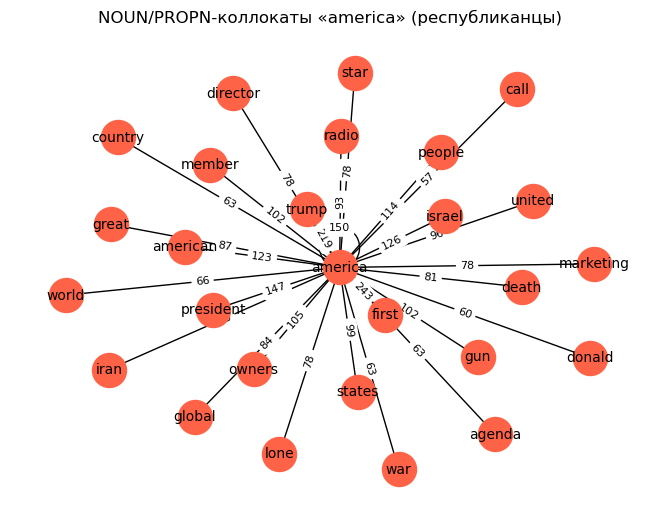

In [42]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "america"
target_skipgrams = [
    sg for sg in cons_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="tomato", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты «america» (республиканцы)")
plt.show()

Фильтрация существительных: 100%|██████████| 16758/16758 [00:36<00:00, 458.04it/s]


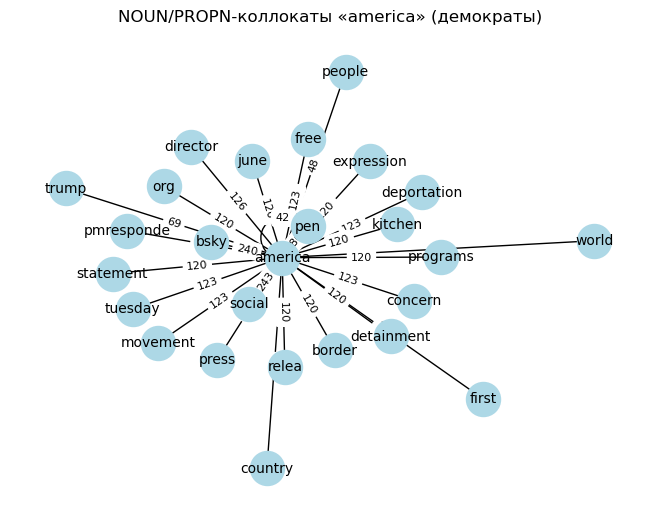

In [43]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "america"
target_skipgrams = [
    sg for sg in libs_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="lightblue", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты «america» (демократы)")
plt.show()

Фильтрация прилагательных: 100%|██████████| 31050/31050 [01:09<00:00, 449.42it/s]


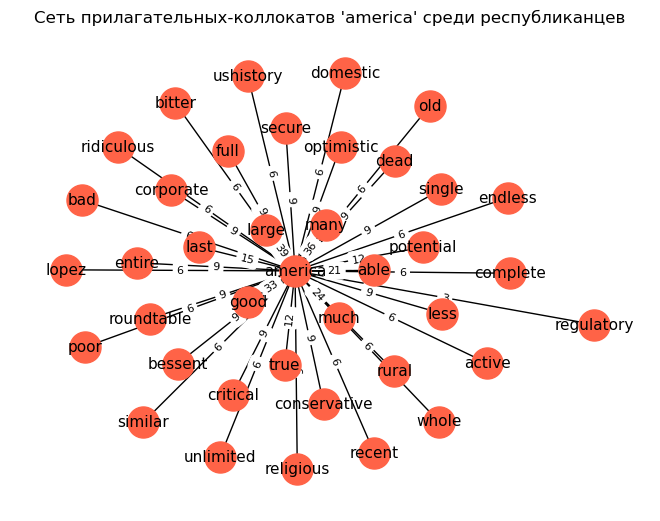

In [44]:
target = 'america'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'america' среди республиканцев")
plt.show()

Фильтрация прилагательных: 100%|██████████| 31050/31050 [01:08<00:00, 455.36it/s]


[(('america', 'large'), 39), (('large', 'america'), 39), (('america', 'many'), 36), (('many', 'america'), 36), (('america', 'good'), 33), (('much', 'america'), 24), (('able', 'america'), 21), (('america', 'last'), 15), (('last', 'america'), 15), (('potential', 'america'), 12), (('america', 'true'), 12), (('true', 'america'), 12), (('secure', 'america'), 9), (('america', 'single'), 9), (('less', 'america'), 9), (('bessent', 'america'), 9), (('america', 'dead'), 9), (('dead', 'america'), 9), (('critical', 'america'), 9), (('america', 'critical'), 9), (('optimistic', 'america'), 9), (('entire', 'america'), 9), (('roundtable', 'america'), 9), (('corporate', 'america'), 9), (('america', 'full'), 9), (('full', 'america'), 9), (('conservative', 'america'), 9), (('rural', 'america'), 9), (('bitter', 'america'), 6), (('america', 'bitter'), 6), (('bad', 'america'), 6), (('complete', 'america'), 6), (('america', 'active'), 6), (('active', 'america'), 6), (('america', 'old'), 6), (('america', 'poo

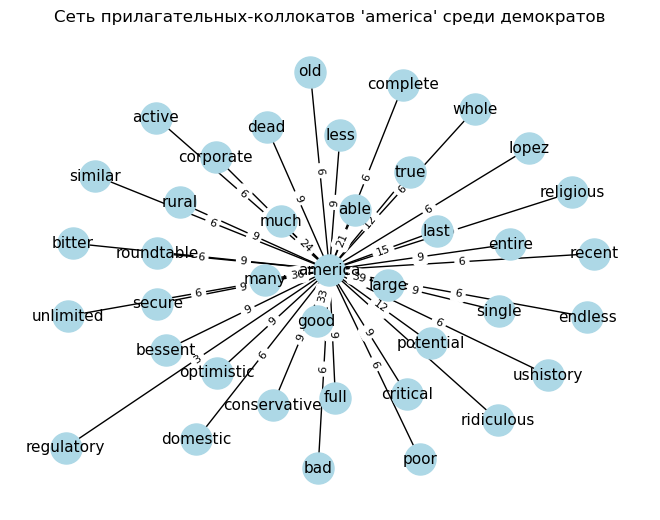

In [45]:
target = 'america'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'america' среди демократов")
plt.show()

[(('people', 'democracy'), 39), (('democracy', 'people'), 39), (('democracy', 'democracy'), 24), (('american', 'democracy'), 24), (('democracy', 'american'), 24), (('defend', 'democracy'), 21), (('democracy', 'defend'), 21), (('democracy', 'freedom'), 21), (('freedom', 'democracy'), 21), (('democracy', 'get'), 21), (('get', 'democracy'), 21), (('rule', 'democracy'), 18), (('democracy', 'rule'), 18), (('like', 'democracy'), 18), (('democracy', 'like'), 18), (('democracy', 'one'), 18), (('one', 'democracy'), 18), (('democracy', 'political'), 18), (('political', 'democracy'), 18), (('democracy', 'willing'), 18), (('willing', 'democracy'), 18), (('pro', 'democracy'), 18), (('democracy', 'pro'), 18), (('democracy', 'say'), 15), (('say', 'democracy'), 15), (('community', 'democracy'), 15), (('every', 'democracy'), 15), (('democracy', 'community'), 15), (('democracy', 'every'), 15), (('military', 'democracy'), 15), (('democracy', 'military'), 15), (('threat', 'democracy'), 15), (('democracy',

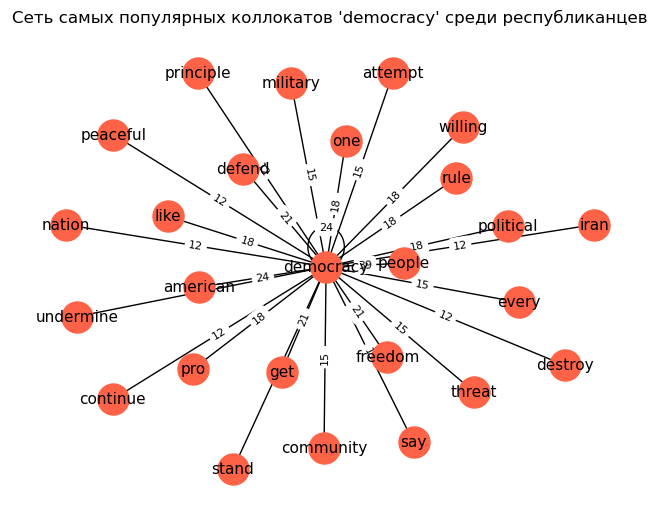

In [46]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'democracy' среди республиканцев")
plt.show()

Фильтрация существительных: 100%|██████████| 23676/23676 [00:51<00:00, 460.28it/s]


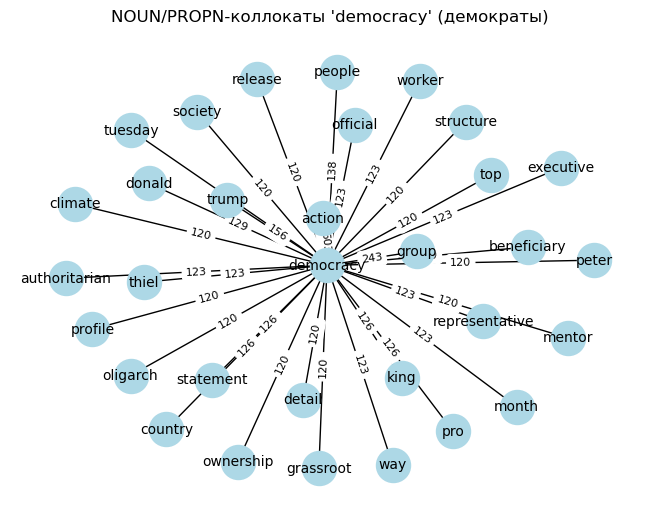

In [49]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "democracy"
target_skipgrams = [
    sg for sg in libs_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="lightblue", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты 'democracy' (демократы)")
plt.show()

[(('people', 'democracy'), 39), (('democracy', 'people'), 39), (('democracy', 'democracy'), 24), (('american', 'democracy'), 24), (('democracy', 'american'), 24), (('defend', 'democracy'), 21), (('democracy', 'defend'), 21), (('democracy', 'freedom'), 21), (('freedom', 'democracy'), 21), (('democracy', 'get'), 21), (('get', 'democracy'), 21), (('rule', 'democracy'), 18), (('democracy', 'rule'), 18), (('like', 'democracy'), 18), (('democracy', 'like'), 18), (('democracy', 'one'), 18), (('one', 'democracy'), 18), (('democracy', 'political'), 18), (('political', 'democracy'), 18), (('democracy', 'willing'), 18), (('willing', 'democracy'), 18), (('pro', 'democracy'), 18), (('democracy', 'pro'), 18), (('democracy', 'say'), 15), (('say', 'democracy'), 15), (('community', 'democracy'), 15), (('every', 'democracy'), 15), (('democracy', 'community'), 15), (('democracy', 'every'), 15), (('military', 'democracy'), 15), (('democracy', 'military'), 15), (('threat', 'democracy'), 15), (('democracy',

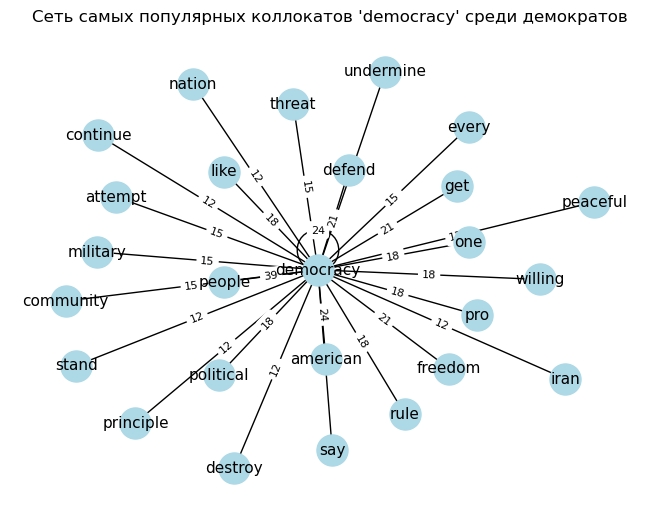

In [47]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'democracy' среди демократов")
plt.show()

Фильтрация существительных: 100%|██████████| 23676/23676 [00:51<00:00, 458.69it/s]


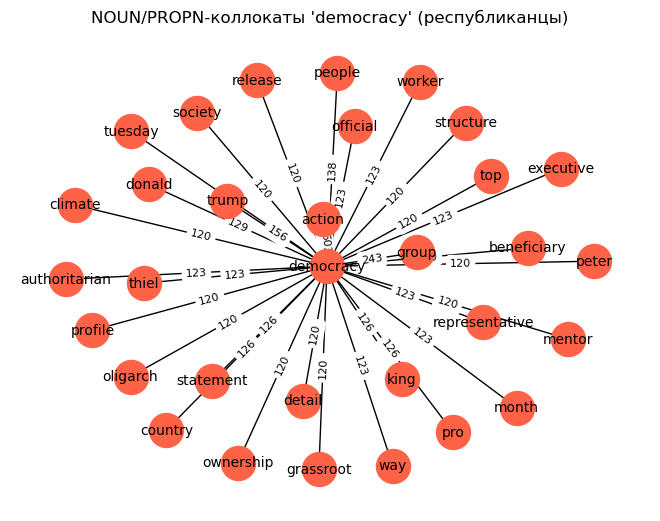

In [50]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "democracy"
target_skipgrams = [
    sg for sg in libs_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="tomato", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты 'democracy' (республиканцы)")
plt.show()

Фильтрация прилагательных: 100%|██████████| 4776/4776 [00:10<00:00, 457.68it/s]


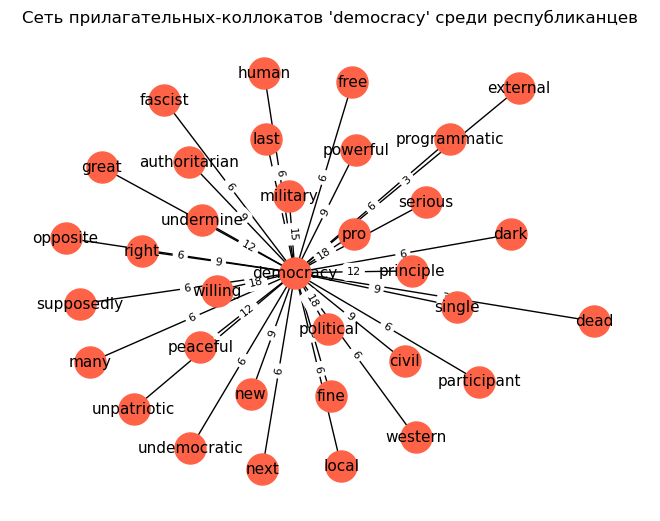

In [51]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'democracy' среди республиканцев")
plt.show()

Фильтрация прилагательных: 100%|██████████| 4776/4776 [00:10<00:00, 457.35it/s]


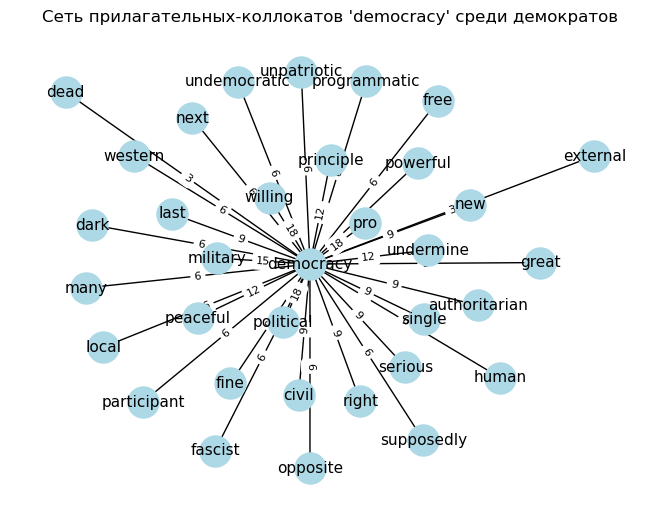

In [52]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'democracy' среди демократов")
plt.show()

Фильтрация глаголов: 100%|██████████| 4776/4776 [00:10<00:00, 454.29it/s]


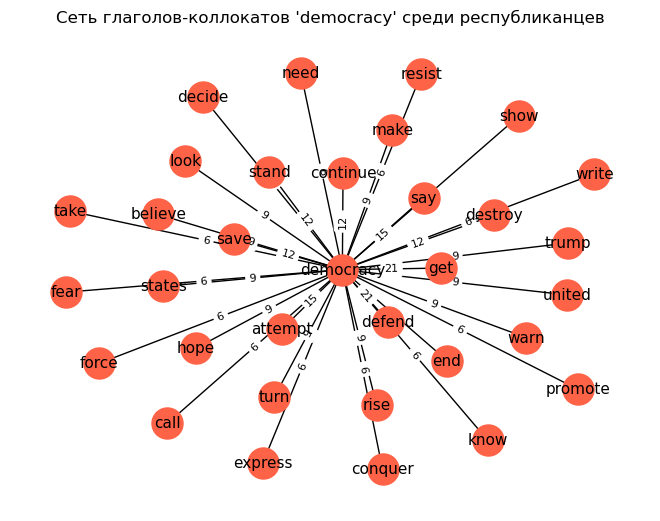

In [53]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация глаголов"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "VERB" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть глаголов-коллокатов 'democracy' среди республиканцев")
plt.show()

Фильтрация глаголов: 100%|██████████| 4776/4776 [00:10<00:00, 466.02it/s]


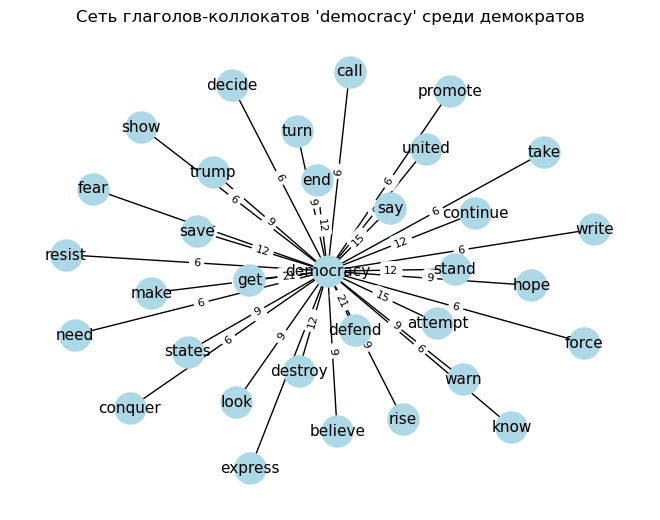

In [54]:
target = 'democracy'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация глаголов"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "VERB" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть глаголов-коллокатов 'democracy' среди демократов")
plt.show()

[(('illegal', 'migrant'), 180), (('migrant', 'illegal'), 180), (('migrant', 'border'), 75), (('border', 'migrant'), 75), (('migrant', 'trump'), 72), (('trump', 'migrant'), 72), (('million', 'migrant'), 57), (('migrant', 'million'), 57), (('migrant', 'states'), 48), (('states', 'migrant'), 48), (('migrant', 'also'), 45), (('also', 'migrant'), 45), (('may', 'migrant'), 45), (('migrant', 'may'), 45), (('migrant', 'say'), 42), (('say', 'migrant'), 42), (('migrant', 'agent'), 42), (('agent', 'migrant'), 42), (('migrant', 'migrant'), 42), (('year', 'migrant'), 39), (('migrant', 'year'), 39), (('biden', 'migrant'), 39), (('migrant', 'biden'), 39), (('migrant', 'legal'), 39), (('legal', 'migrant'), 39), (('nearly', 'migrant'), 39), (('migrant', 'nearly'), 39), (('release', 'migrant'), 39), (('migrant', 'release'), 39), (('migrant', 'united'), 39), (('united', 'migrant'), 39), (('ice', 'migrant'), 36), (('migrant', 'ice'), 36), (('american', 'migrant'), 36), (('migrant', 'american'), 36), (('ar

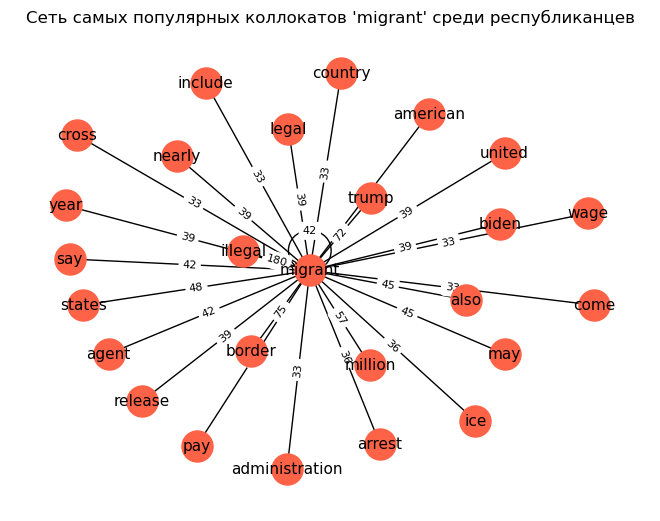

In [55]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'migrant' среди республиканцев")
plt.show()

[(('illegal', 'migrant'), 180), (('migrant', 'illegal'), 180), (('migrant', 'border'), 75), (('border', 'migrant'), 75), (('migrant', 'trump'), 72), (('trump', 'migrant'), 72), (('million', 'migrant'), 57), (('migrant', 'million'), 57), (('migrant', 'states'), 48), (('states', 'migrant'), 48), (('migrant', 'also'), 45), (('also', 'migrant'), 45), (('may', 'migrant'), 45), (('migrant', 'may'), 45), (('migrant', 'say'), 42), (('say', 'migrant'), 42), (('migrant', 'agent'), 42), (('agent', 'migrant'), 42), (('migrant', 'migrant'), 42), (('year', 'migrant'), 39), (('migrant', 'year'), 39), (('biden', 'migrant'), 39), (('migrant', 'biden'), 39), (('migrant', 'legal'), 39), (('legal', 'migrant'), 39), (('nearly', 'migrant'), 39), (('migrant', 'nearly'), 39), (('release', 'migrant'), 39), (('migrant', 'release'), 39), (('migrant', 'united'), 39), (('united', 'migrant'), 39), (('ice', 'migrant'), 36), (('migrant', 'ice'), 36), (('american', 'migrant'), 36), (('migrant', 'american'), 36), (('ar

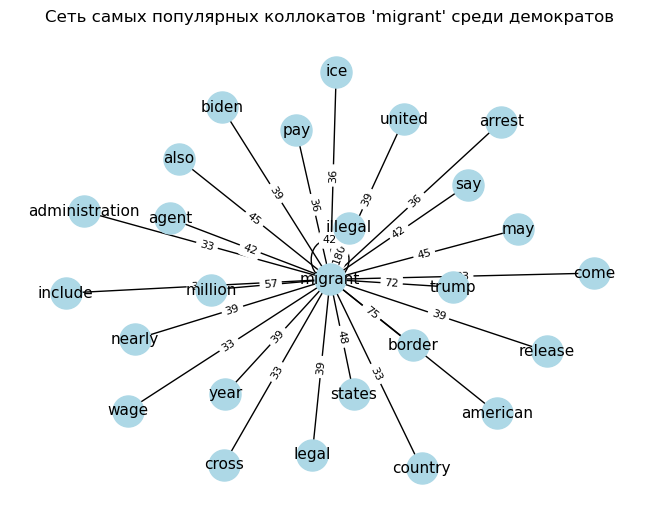

In [56]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

target_skipgram_counts = Counter(target_skipgrams)
print(target_skipgram_counts.most_common())

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
        G.add_edge(word1, word2, weight=count)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть самых популярных коллокатов 'migrant' среди демократов")
plt.show()

Фильтрация существительных: 100%|██████████| 1620/1620 [00:03<00:00, 448.56it/s]


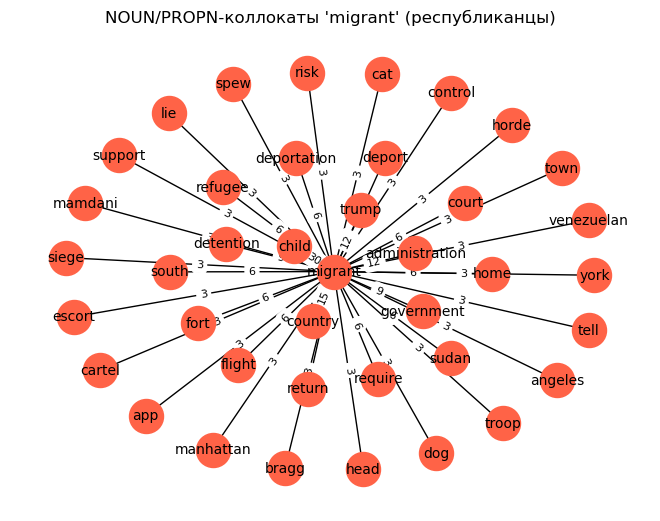

In [57]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "migrant"
target_skipgrams = [
    sg for sg in libs_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="tomato", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты 'migrant' (республиканцы)")
plt.show()

Фильтрация существительных: 100%|██████████| 1620/1620 [00:03<00:00, 450.00it/s]


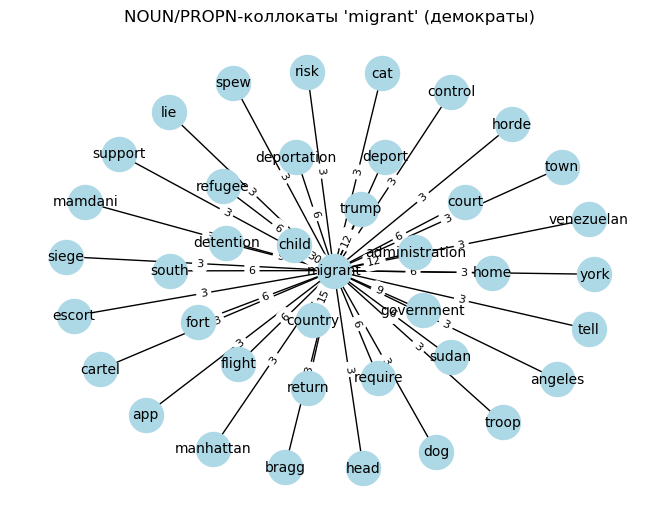

In [58]:
ALLOWED_POS = {"NOUN", "PROPN"}

target = "migrant"
target_skipgrams = [
    sg for sg in libs_all
    if sg[0] == target or sg[1] == target
]

noun_skipgrams = []
for w1, w2 in tqdm(target_skipgrams, desc="Фильтрация существительных"):
    doc = nlp(f"{w1} {w2}")
    if len(doc) == 2 and all(tok.pos_ in ALLOWED_POS for tok in doc):
        noun_skipgrams.append((w1, w2))


counts = Counter(noun_skipgrams)

G = nx.Graph()
for (w1, w2), cnt in counts.most_common(50):
    G.add_edge(w1, w2, weight=cnt)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True,
        node_color="lightblue", node_size=600, font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8
)
plt.title("NOUN/PROPN-коллокаты 'migrant' (демократы)")
plt.show()

Фильтрация прилагательных: 100%|██████████| 15378/15378 [00:33<00:00, 456.08it/s]


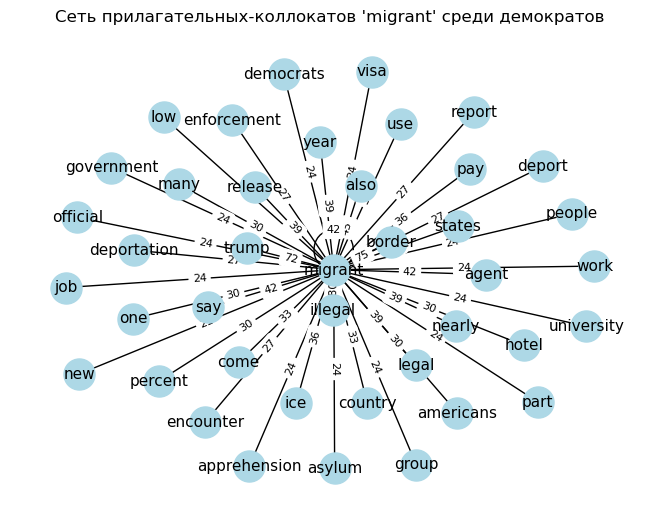

In [59]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'migrant' среди демократов")
plt.show()

Фильтрация прилагательных: 100%|██████████| 15378/15378 [00:33<00:00, 461.41it/s]


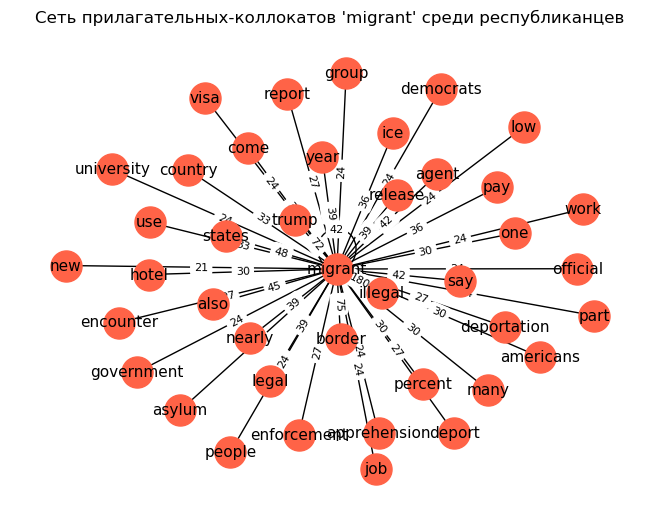

In [60]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация прилагательных"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "ADJ" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть прилагательных-коллокатов 'migrant' среди республиканцев")
plt.show()

Фильтрация глаголов: 100%|██████████| 15378/15378 [00:34<00:00, 452.06it/s]


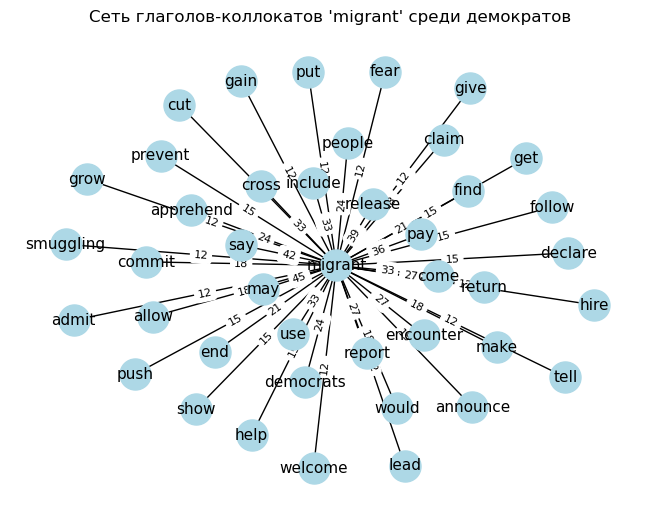

In [61]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация глаголов"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "VERB" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть глаголов-коллокатов 'migrant' среди демократов")
plt.show()

Фильтрация глаголов: 100%|██████████| 15378/15378 [00:33<00:00, 452.73it/s]


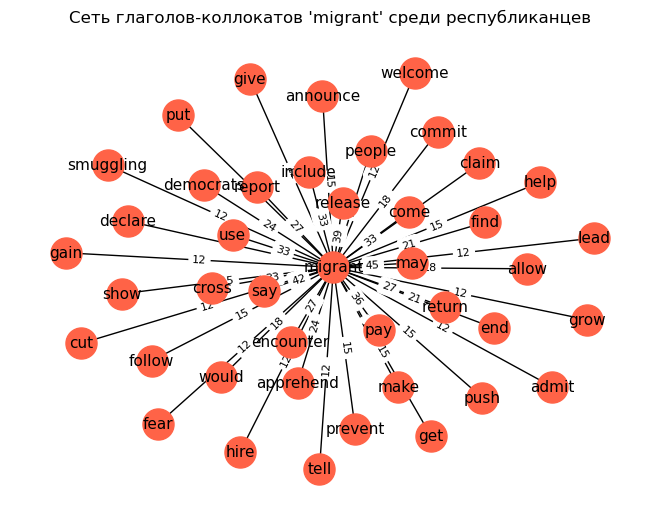

In [62]:
target = 'migrant'
target_skipgrams = []
for skipgram in cons_all:
    if skipgram[0] == target or skipgram[1] == target:
        target_skipgrams.append(skipgram)

adj_skipgrams = []
for word1, word2 in tqdm(target_skipgrams, desc="Фильтрация глаголов"):
    doc = nlp(f"{word1} {word2}")
    if any(tok.pos_ == "VERB" for tok in doc):
        adj_skipgrams.append((word1, word2))

target_skipgram_counts = Counter(adj_skipgrams)

G = nx.Graph()
for (word1, word2), count in target_skipgram_counts.most_common(50):
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='tomato', node_size=500, font_size=11)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Сеть глаголов-коллокатов 'migrant' среди республиканцев")
plt.show()

GENSIM

In [63]:
WINDOW_SIZE = 5
MIN_COUNT = 5
VEC_SIZE = 200
N_WORKERS = multiprocessing.cpu_count()

LIB_PATH = Path("commondreams_texts.txt")
LIB_PATH2 = Path("motherjones_texts.txt")
CONS_PATH = Path("breitbart_texts.txt")

def corpus_chunks(text, chunk_size=100_000):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield " ".join(words[i : i + chunk_size])


def preprocess_textfile(path: Path):
    text = path.read_text(encoding="utf-8", errors="ignore")
    text = re.sub(r"[.\n,]", " ", text)
    text = re.sub(r"\[[^\]]*?\]", "", text)
    text = re.sub(r"\s{2,}", " ", text)

    corpus = []
    for chunk in tqdm(corpus_chunks(text), desc=f"Processing {path.name}"):
        doc = nlp(chunk)
        named_entities = {ent.text for ent in doc.ents}

        lemmas = [
            tok.lemma_.lower()
            for tok in doc
            if tok.is_alpha
            and len(tok.lemma_) > 2
            and tok.lemma_.lower() not in stopwords_en
            and tok.text not in named_entities
        ]
        corpus.append(lemmas)
    return corpus


libs_corpus = preprocess_textfile(LIB_PATH) + preprocess_textfile(LIB_PATH2)
cons_corpus = preprocess_textfile(CONS_PATH)

w2v_libs = gensim.models.Word2Vec(
    sentences=libs_corpus,
    vector_size=VEC_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=N_WORKERS,
    sg=1,
)

w2v_cons = gensim.models.Word2Vec(
    sentences=cons_corpus,
    vector_size=VEC_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=N_WORKERS,
    sg=1,
)

w2v_libs.save("w2v_libs.model")
w2v_cons.save("w2v_cons.model")

Processing commondreams_texts.txt: 5it [01:14, 14.87s/it]
Processing motherjones_texts.txt: 4it [00:53, 13.31s/it]
Processing breitbart_texts.txt: 6it [01:27, 14.56s/it]


In [64]:
libs_kv, cons_kv = w2v_libs.wv, w2v_cons.wv

words = [
    "freedom", "government",
    "immigration", "security", "tax",
    "climate", "abortion", "border",
    "crime", "election"
]

def topn(model, word, n=10):
    return [w for w, _ in model.most_similar(word, topn=n)]

rows = []
for w in words:
    rows.append(
        {
            "word": w,
            "libs_top10": ", ".join(topn(libs_kv, w)),
            "cons_top10": ", ".join(topn(cons_kv, w)),
        }
    )
df = pd.DataFrame(rows)

markdown_table = tabulate(
    df,
    headers="keys",
    tablefmt="github",
    showindex=False
)

print("\nTop-10 neighbours")
print(markdown_table)


Top-10 neighbours
| word        | libs_top10                                                                                              | cons_top10                                                                                                      |
|-------------|---------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|
| freedom     | holiday, presence, whose, warning, destination, pull, jurisdiction, noncitizen, disturbing, speculation | non, secure, suggest, toward, finally, accept, permit, supporter, create, reference                             |
| government  | efficiency, overthrow, loot, presidency, pocket, sycamore, oligarchy, board, timber, line               | power, clear, put, reason, state, keep, sure, try, case, move                                                   |
| immigration | enforcement, jersey, 

In [65]:
# вектора частотных токенов республиканцев
freq_tokens = w2v_cons.wv.key_to_index  
words = list(freq_tokens.keys())[:500]
cons_vectors = np.array([w2v_cons.wv[word] for word in words])

# снижение размерности
tsne = TSNE(n_components=2, random_state=17, perplexity=30, max_iter=1000)
tsne_vectors = tsne.fit_transform(cons_vectors)
tsne_vectors[:10]

# кластеризация
n_clusters = 7 
kmeans = KMeans(n_clusters=n_clusters, random_state=17)
clusters = kmeans.fit_predict(tsne_vectors)

In [66]:
fig = go.Figure()
for i, word in enumerate(words):
    x, y = tsne_vectors[i, :]
    color = px.colors.qualitative.Plotly[clusters[i] % len(px.colors.qualitative.Plotly)]
    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[y],
            mode="markers+text",
            text=[word],
            textposition="top center",
            marker=dict(size=8, color=color, opacity=0.7),
            hovertemplate=f"Слово: {word}<br>Кластер: {clusters[i]}<br>t-SNE 1: {x:.2f}<br>t-SNE 2: {y:.2f}"
        )
    )

fig.update_layout(
    title="Топ-500 слов",
    showlegend=False,
    hovermode="closest",
    width=1000,
    height=800,
    template="plotly_white"
)
fig.show()

In [67]:
# вектора частотных токенов демократов
freq_tokens = w2v_libs.wv.key_to_index  
words = list(freq_tokens.keys())[:500]
libs_vectors = np.array([w2v_libs.wv[word] for word in words])

# снижение размерности
tsne = TSNE(n_components=2, random_state=17, perplexity=30, max_iter=1000)
tsne_vectors = tsne.fit_transform(libs_vectors)
tsne_vectors[:10]

# кластеризация
n_clusters = 7 
kmeans = KMeans(n_clusters=n_clusters, random_state=17)
clusters = kmeans.fit_predict(tsne_vectors)

In [68]:
fig = go.Figure()
for i, word in enumerate(words):
    x, y = tsne_vectors[i, :]
    color = px.colors.qualitative.Plotly[clusters[i] % len(px.colors.qualitative.Plotly)]
    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[y],
            mode="markers+text",
            text=[word],
            textposition="top center",
            marker=dict(size=8, color=color, opacity=0.7),
            hovertemplate=f"Слово: {word}<br>Кластер: {clusters[i]}<br>t-SNE 1: {x:.2f}<br>t-SNE 2: {y:.2f}"
        )
    )

fig.update_layout(
    title="Топ-500 слов",
    showlegend=False,
    hovermode="closest",
    width=1000,
    height=800,
    template="plotly_white"
)
fig.show()